In [1]:
import pandas as pd
import numpy as np
import pylab
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
register_matplotlib_converters()
%matplotlib inline

Let's simulate a process from the following ARIMA model:

$z_t = 0.3z_{t - 1} - 0.1\epsilon_{t - 1} + \epsilon_t$

Where $z_t = y_t - y_{t - 1}$ and $\epsilon \sim N(0, 1)$

<AxesSubplot:>

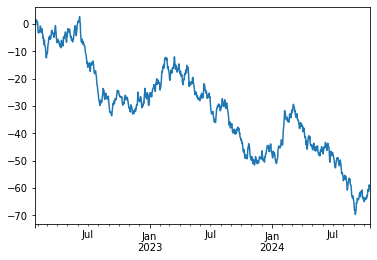

In [5]:
n = 1000

startdate = '2022-01-25'
daterange = pd.date_range(start=startdate, periods=n)

empty_dataset = np.zeros(n)
mod = SARIMAX(empty_dataset, order=(1, 1, 1), initialization='diffuse')
series = pd.Series(mod.simulate([0.3, -0.1, 1], n), index=daterange)
series.plot()

<AxesSubplot:>

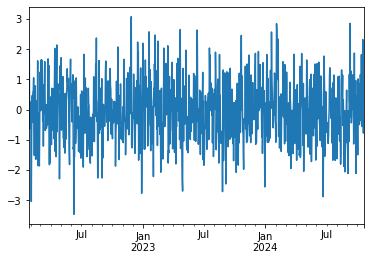

In [6]:
diffs = series.diff().dropna()
diffs.plot()

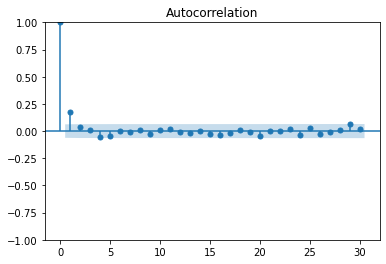

In [7]:
acf_plot = plot_acf(diffs)

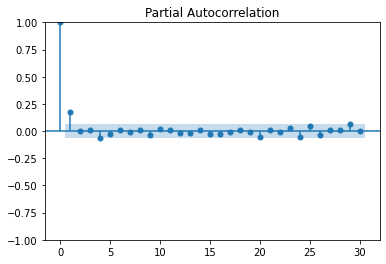

In [8]:
pacf_plot = plot_pacf(diffs, method='ywm')

In [11]:
train_end = datetime(2024, 9, 1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):]

In [12]:
#create the model
model = SARIMAX(train_data, order=(1, 1, 1))
#fit the model
model_fit = model.fit()
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  951
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1336.454
Date:                Mon, 07 Feb 2022   AIC                           2678.908
Time:                        19:38:38   BIC                           2693.478
Sample:                    01-25-2022   HQIC                          2684.460
                         - 09-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2074      0.177      1.170      0.242      -0.140       0.555
ma.L1         -0.0240      0.183     -0.131      0.896      -0.383       0.335
sigma2         0.9759      0.047     20.964      0.0

Our fitted model is $\hat{z_t} = 0.2z_{t - 1} - 0.02\epsilon_{t - 1} + \epsilon_t$ where $\epsilon \sim N(0, 0.98)$

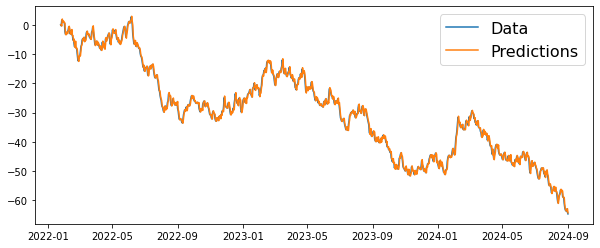

In [13]:
pylab.figure(figsize=(10,4))

pylab.plot(train_data)
pylab.plot(model_fit.predict(start=train_data.index[0], train_data=series.index[-1]))

pylab.legend(('Data', 'Predictions'), fontsize=16)

In [26]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [27]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

Text(0.5, 1.0, 'MA2 Simulation over time')

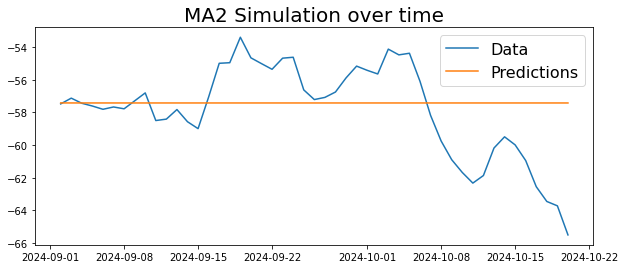

In [28]:
pylab.figure(figsize=(10,4))

pylab.plot(test_data)
pylab.plot(predictions)

pylab.legend(('Data', 'Predictions'), fontsize=16)

pylab.title('MA2 Simulation over time', fontsize=20)

In [33]:
residuals = test_data - predictions

In [34]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0369


In [35]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2.8354026090069886


Text(0, 0.5, 'Error')

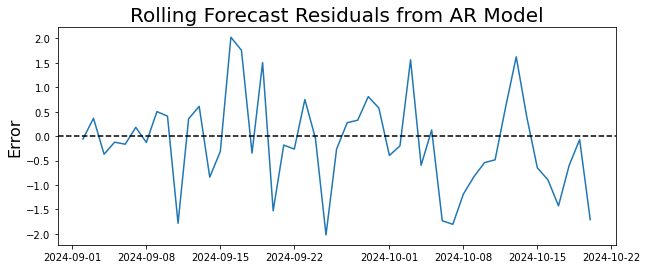

In [30]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = series[:train_end - timedelta(days=1)]
    model = SARIMAX(train_data, order=(1,1,1))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred
    
rolling_residuals = test_data - rolling_predictions
pylab.figure(figsize=(10,4))
pylab.plot(rolling_residuals)
pylab.axhline(0, linestyle='--', color='k')
pylab.title('Rolling Forecast Residuals from AR Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)

In [31]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0128


In [32]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 0.9565483460406409


For another example, see this post from Jason Brownlee https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ 